In [12]:
!pip install matplotlib

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import random
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader

from datasets_gen import get_mnist_
from noise_scheduler import noise_scheduler,get_at
import unet

In [14]:
Device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
im_data=get_mnist_(normalize=True)
im_data = F.pad(im_data, (1, 2, 1, 2), mode='constant', value=-1)
im_data=im_data.unsqueeze(1)
im_tensor=TensorDataset(im_data,im_data)
trainloader= DataLoader(im_tensor,batch_size=64,shuffle=True)

In [16]:
model=unet.Unet(1,8)
model=model.to(Device)
optim=torch.optim.Adam(model.parameters(),lr=0.001)
criterion=F.mse_loss

In [33]:
# Set the number of epochs
num_epochs = 100
loss_list=[]

for epoch in range(num_epochs):
    count=0
    total_loss=0
    for images,_ in trainloader:
        images = images.to(Device)
        b,f,c,c=images.shape
        t=random.randint(1,1000)
        noise=torch.randn(b,f,c,c).to(Device)
        
        noised_image = noise_scheduler(images,noise,t)
        pred_noise=model(noised_image,t)
        loss = criterion(pred_noise,noise)

        count+=1
        total_loss+=loss.item()
        
        loss.backward(retain_graph=True)
        optim.step()
        optim.zero_grad()

    print(f"Epoch [{epoch+1}/{num_epochs}], Avg_Loss: {total_loss/count:.4f}, Sum_loss:{total_loss:.4f}")

Epoch [1/100], Avg_Loss: 0.0071, Sum_loss:6.6732
Epoch [2/100], Avg_Loss: 0.0064, Sum_loss:6.0089
Epoch [3/100], Avg_Loss: 0.0071, Sum_loss:6.6787
Epoch [4/100], Avg_Loss: 0.0064, Sum_loss:5.9938
Epoch [5/100], Avg_Loss: 0.0066, Sum_loss:6.2022
Epoch [6/100], Avg_Loss: 0.0066, Sum_loss:6.1627
Epoch [7/100], Avg_Loss: 0.0072, Sum_loss:6.7894


KeyboardInterrupt: 

In [34]:
def DDPM_sampler(model,images,t,n=0.5):
  with torch.no_grad():

      #model.eval
      shape=images.shape
      pred_noise=model(images,t)
      at=get_at(t)
      at1=get_at(t-1)
      base_at=at/at1
      c=(1-base_at)/(math.sqrt(1-at))

      if t>1:
        pred_image=math.sqrt(1/(base_at))*(images-c*pred_noise) + torch.randn(shape,device=Device)*math.sqrt(1-base_at)

      else:
        pred_image=math.sqrt(1/(base_at))*(images-c*pred_noise)

      return pred_image

In [40]:
def DDIM_sampler(model,images,t,n=1):
    with torch.no_grad():

        model.eval()
        shape=images.shape
        pred_noise=model(images,t)
        at=get_at(t)
        at1=get_at(t-1)
        pred_x0=math.sqrt(at1/at)*(images-math.sqrt(1-at)*pred_noise)

        if t>1:
          sigma=n*((1-at1)/(1-at))*(1-(at/at1))
          dir_xt=math.sqrt(1-at1-sigma)*pred_noise
          random_noise=torch.randn(shape,device=Device)*math.sqrt(sigma)
          images=pred_x0+dir_xt+random_noise

        else:
          images=pred_x0

        return images

1000


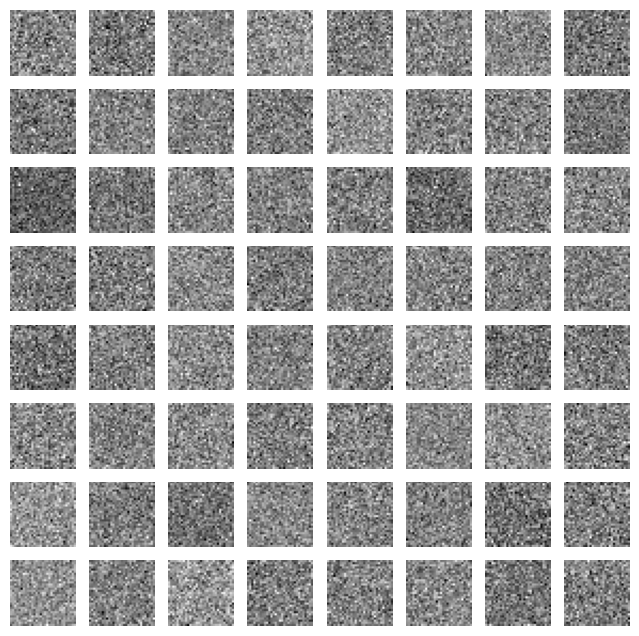

900


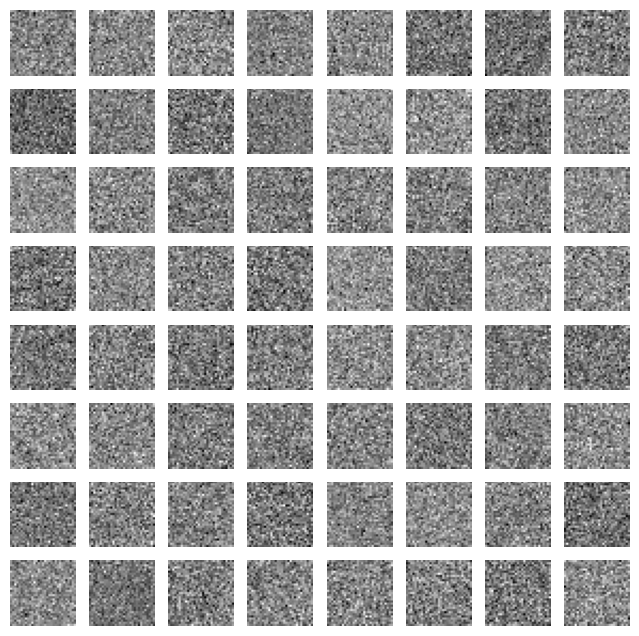

800


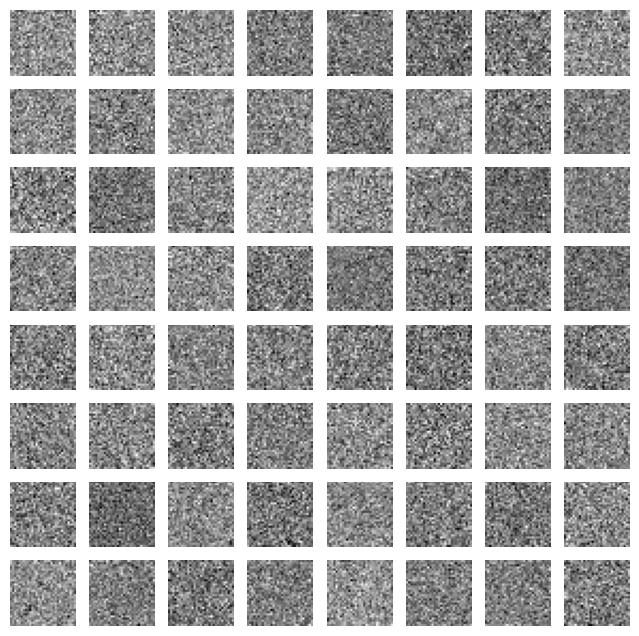

700


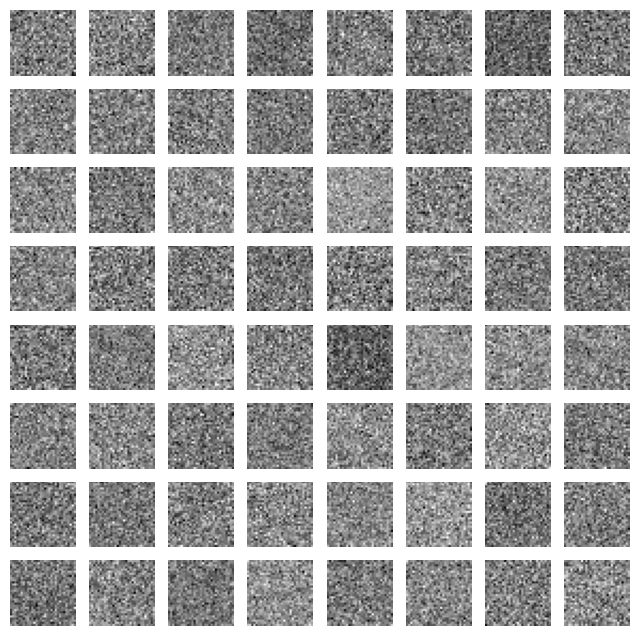

600


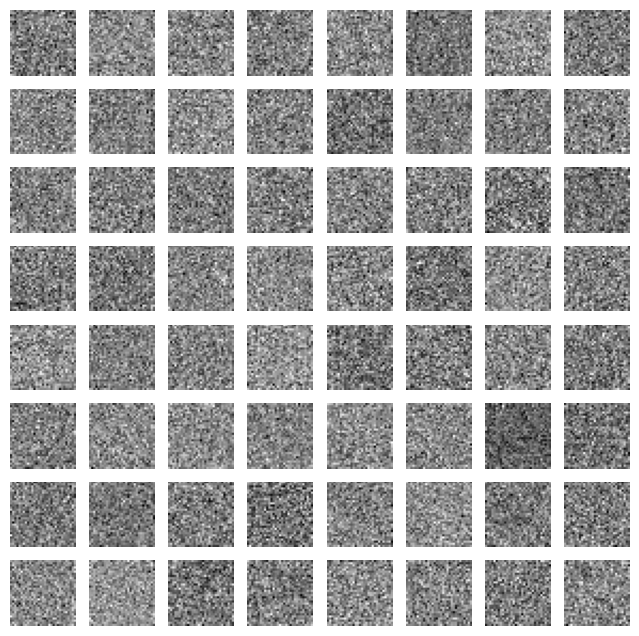

500


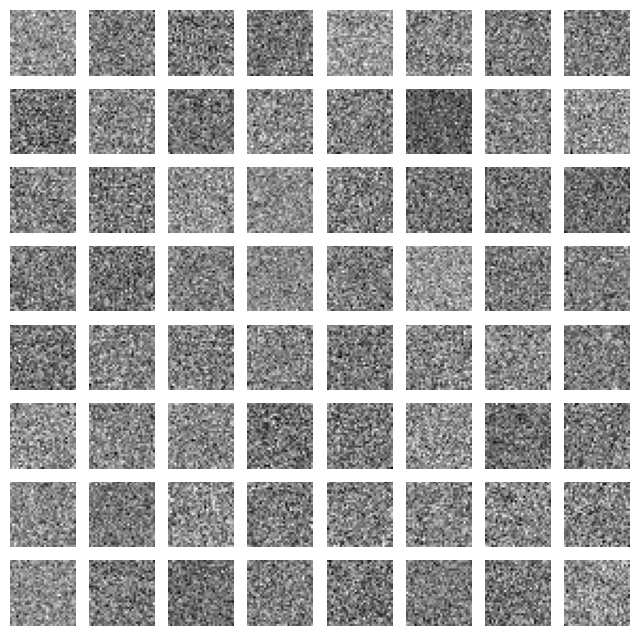

400


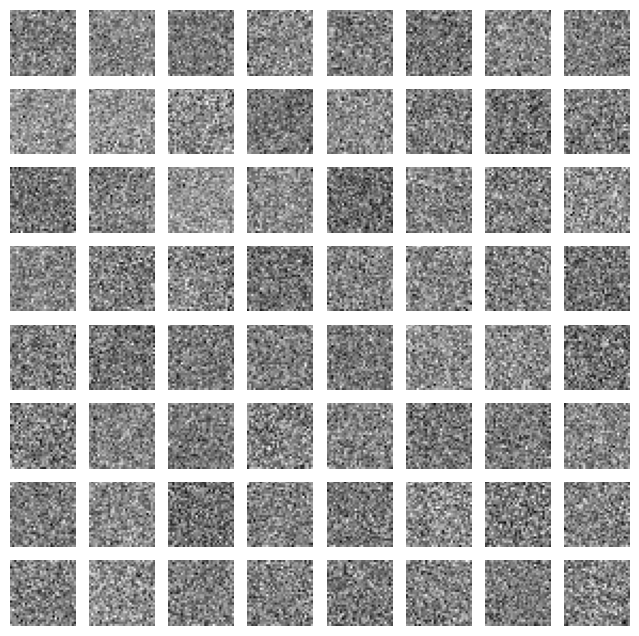

300


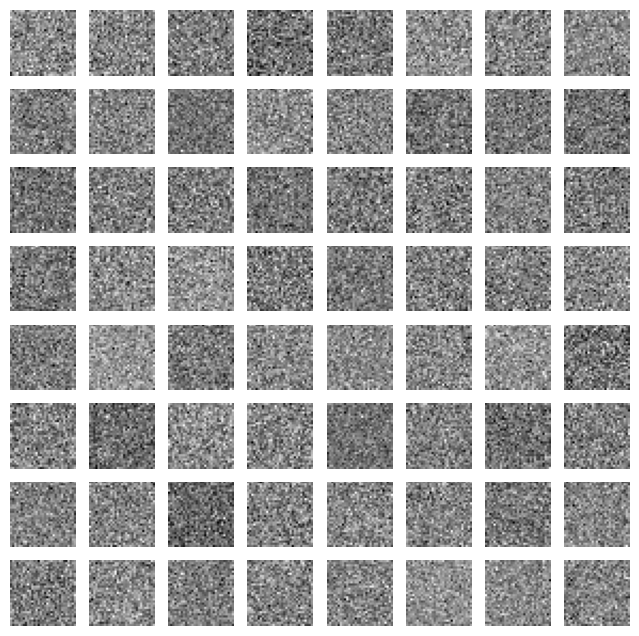

200


In [ ]:
x=torch.randn(64,1,31,31).to(Device)
timesteps=1000
for i in range(0,timesteps):
    t=timesteps-i
    x=DDIM_sampler(model,x,t,1)
    
    if(t%100==0 or t==1):
        y = x[:64]
        y=y.view(8,8,31,31)
        y=y.to('cpu:0')
        y = y.numpy()
        fig, axes = plt.subplots(8, 8, figsize=(8, 8))
        for i in range(8):
          for j in range(8):
              axes[i, j].imshow(y[i,j],cmap='gray')
              axes[i, j].axis('off')
        print(t)
        plt.savefig('samples.jpeg')
        plt.show()

In [37]:
def DDIM_sampler(model,images,noise,t):
    with torch.no_grad():
        model.eval()
        noised_image = images
        shape=noised_image.shape
        pred_noise=model(noised_image,t)
        at=get_at(t)
        at1=get_at((t-1))
        pred_x0=(math.sqrt(at)*(images-math.sqrt(1-at)*pred_noise))/at1
        sigma=0.2*((1-at)/(1-at1))*(1-(at/at1))
        #print(t,sigma,at,at1)
        print(1-at1-sigma)
        dir_xt=math.sqrt(1-at1-sigma)*pred_noise
        random_noise=torch.randn(shape)*math.sqrt(sigma)
        images=pred_x0+dir_xt+random_noise
        return images

In [38]:
x=torch.randn(64,1,31,31).to(Device)
timesteps=90
for i in range(timesteps-1):
    t=timesteps-i
    noise=torch.randn(64,1,31,31).to(Device)
    x=DDIM_sampler(model,x,noise,t)

x = x[:64].view(8, 8, 31, 31)
x = x.to('cpu')
image_np = x.numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels
plt.savefig('samples.jpeg')
plt.show()
    

0.8300654383145553


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
def DDIM_sampler(model,at=0.99,ts=650):
    with torch.no_grad():
        model.eval()
        image=torch.randn(64,1,31,31).to(Device)
        for t in range(1,ts):
            noise=torch.randn(64,1,31,31).to(Device)
            pred_noise=model(image,ts-t)
            #pred_noise_t1=model(image,ts-t-1)
            vart=math.sqrt(1-math.pow(at,ts-t))
            vart1=math.sqrt(1-math.pow(at,ts-t))
            alpha=(1-at)/vart
            if t < 0.85*ts:
              image=(image-alpha*pred_noise)/math.sqrt(at) 
            else:
              image=(image-alpha*pred_noise)/math.sqrt(at)
    return image


In [ ]:
im=DDIM_sampler(model,ts=450)
x=im[:64]
x = x[:64].view(8, 8, 31, 31)
x = x.to('cpu')
image_np = x.numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels
plt.savefig('samples.jpeg')
plt.show()